In [1]:
import numpy as np
import scipy.stats as spstats
from scipy import signal
import pickle
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sparse
import seaborn as sns

from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,potentialRegression,BananaShape
from baselines import GenerateSigma,construct_ESVM_kernel,set_function
from optimize import Run_eval_test,optimize_parallel_new 
from samplers import MCMC_sampler,Generate_train
from utils import *

In [2]:
N_b = 1*10**5 # Burn in period
N_train = 1*10**6 # Number of samples on which we optimize
N_test = 1*10**6 # Number of samples
step = 0.2 # Step size
n_traj_train = 1
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "posterior_mean"

In [3]:
"""
%load_ext line_profiler

%lprun -f construct_Eric_kernel construct_Eric_kernel(N_train)
"""

'\n%load_ext line_profiler\n\n%lprun -f construct_Eric_kernel construct_Eric_kernel(N_train)\n'

The cell below is to certify the correctness of fft convolutions, add later to test.py

In [4]:
"""
#csr matrix
W_train_sparse = construct_Eric_kernel_sparse(N_train)
#just one column
c_fft = construct_Eric_kernel(N_train)
print(c_fft.shape)
#time test
import time
x = np.random.randn(N_train)
print(x.shape)
start_time = time.time()
res_dense = PWP(x,W_train_sparse)
print("csr time = ",time.time()-start_time)
start_time = time.time()
res_fft = PWP_fast(x,c_fft)
print("fft time = ",time.time()-start_time)
print("error: ",np.linalg.norm(res_fft - res_dense)/np.linalg.norm(x))
"""

'\n#csr matrix\nW_train_sparse = construct_Eric_kernel_sparse(N_train)\n#just one column\nc_fft = construct_Eric_kernel(N_train)\nprint(c_fft.shape)\n#time test\nimport time\nx = np.random.randn(N_train)\nprint(x.shape)\nstart_time = time.time()\nres_dense = PWP(x,W_train_sparse)\nprint("csr time = ",time.time()-start_time)\nstart_time = time.time()\nres_fft = PWP_fast(x,c_fft)\nprint("fft time = ",time.time()-start_time)\nprint("error: ",np.linalg.norm(res_fft - res_dense)/np.linalg.norm(x))\n'

In [5]:
method = {"sampler":"MALA","burn_type":"full","main_type":"full"} # Sampling method

In [6]:
B = 0.1
M = 100.0
d = 8
W_train_spec = construct_ESVM_kernel(N_train)
W_test_spec = construct_ESVM_kernel(N_test)
Cur_pot = BananaShape(B,M,d)
#sample for variance reduction
seed = 777
if method["sampler"] == "ULA":
    res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12
accepted =  664287


In [7]:
if (f_type == "posterior_mean"):
    inds_arr = np.array([1]) # Taking the second index (not intercept)
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
    inds_arr = np.array([0])
    
f_vals = set_function(f_type,traj,inds_arr,params)

In [8]:
n_restarts = 2 # Number of restarts during optimization
sigma = 1 # Deviation of starting points
tol = 1e-5 # Tolerance (for the norm of gradient)

In [9]:
A_ESVM_1,A_EVM_1,A_LS_1 = optimize_parallel_new(1,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)
A_ESVM_2,A_EVM_2,A_LS_2 = optimize_parallel_new(2,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)

1 degree optimization terminated succesfully
jacobian at termination: 
[-1.12237442e-06  2.93146090e-07  2.41353731e-06 -1.25102274e-06
  1.10893656e-06  1.19123375e-07  1.16769172e-06  1.12158276e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[-9.22584586e-07  1.83273491e-07  2.14205695e-06 -9.28575591e-07
  1.03130540e-06  2.32614580e-08  1.12937265e-06  1.28772376e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[-5.12596136e-06 -9.07153445e-07 -1.11736065e-06 -1.72287296e-07
  3.71270448e-07  3.13400322e-06 -2.29391926e-06  9.54799443e-07]
2 degree optimization terminated succesfully
Jacobian matrix at termination: 
[-1.30264614e-07 -9.55575443e-08  2.92352262e-06  1.66033471e-06
  1.18335666e-06 -1.57484204e-07  3.69106324e-06  5.72580654e-07
  3.20518108e-06  4.79336438e-06  9.92220469e-07 -7.22578383e-07
  1.15056003e-07 -3.53691884e-07 -3.45495775e-07 -3.72329534e-07
  4.79336438e-06 -1.36392439e-06 -3.41169925e-07  1.5615

## Coefficients for control variates

In [10]:
print("Coefficients for ESVM")
print(A_ESVM_1)
print("Coefficients for EVM")
print(A_EVM_1)
print("Coefficients for LS")
print(A_LS_1)

Coefficients for ESVM
[[ 19.24552213 141.8190486    9.03502458   5.02560196  26.72846584
    8.84398718 -31.56691807   9.69222956]]
Coefficients for EVM
[[-0.17343524  1.78429638  0.1069116   0.32554337  1.50932331  1.33421857
  -1.80753475  0.57178606]]
Coefficients for LS
[[-0.20162728  1.99101141  0.11214539  0.40725771  1.78477273  1.49219982
  -2.01216069  0.58160999]]


In [11]:
print("Coefficients for ESVM")
print(A_ESVM_2)
print("Coefficients for EVM")
print(A_EVM_2)
print("Coefficients for LS")
print(A_LS_2)

Coefficients for ESVM
[[ 6.70939693e+00  2.02032790e+02  1.88875586e-01 -1.53578643e+00
  -1.02715838e+00  2.52400445e+00 -3.62445333e+00  3.38124859e+00
  -4.98120226e+00 -7.93202353e-03  1.73208414e-01  1.52443468e-01
  -2.12797255e-02 -1.30319419e-01 -2.41599331e-01  2.06338145e-01
  -7.93201667e-03 -1.01748805e+01 -6.55715771e-02 -4.09054390e-02
   1.37017110e-02  7.89064986e-02  4.19098689e-02 -5.28825057e-02
   1.73208337e-01 -6.55716000e-02 -1.07041612e+00  6.50994272e-01
  -8.06218267e-01 -3.70210430e-01  8.23446653e-03  2.71969019e+00
   1.52443458e-01 -4.09054409e-02  6.50994297e-01 -4.20357753e+00
   1.38404359e+00  3.37583854e-01  4.99630914e-01  1.39753029e+00
  -2.12797093e-02  1.37017026e-02 -8.06218097e-01  1.38404363e+00
  -3.18050161e+00  1.68680439e+00 -3.50709223e-01 -1.02807098e+00
  -1.30319380e-01  7.89065011e-02 -3.70210538e-01  3.37584210e-01
   1.68680440e+00 -8.01834011e-01 -1.19322030e+00  1.10137280e+00
  -2.41599261e-01  4.19098439e-02  8.23442217e-03  4.9

### Test 

In [12]:
# Create a dictionary, put respective matrices into it
CV_dict = {"ZAV":[A_ESVM_1,A_ESVM_2],"ZV":[A_EVM_1,A_EVM_2],"LS":[A_LS_1,A_LS_2]}
# Number of cores exploited for the computation of the independent trajectories
# by deault, all available cores on the machine
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,method,inds_arr,Cur_pot,W_test_spec,CV_dict,step,N_b,N_test,d,params,f_type) for i in range (n_traj_test)])
trav.close()
res_arr = np.asarray(res) # Saving results as np.array

### Results

In [13]:
print("Estimators")
print("Vanilla MC {}".format(np.mean(res_arr[:,0,0,:],axis=0)))
print("ESVM pol=1 {}".format(np.mean(res_arr[:,0,1,:],axis=0)))
print("ESVM pol=2 {}".format(np.mean(res_arr[:,0,2,:],axis=0)))
print("EVM pol=1 {}".format(np.mean(res_arr[:,0,3,:],axis=0)))
print("EVM pol=2 {}".format(np.mean(res_arr[:,0,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,0,3,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,0,4,:],axis=0)))

Estimators
Vanilla MC [0.0079742]
ESVM pol=1 [0.11735668]
ESVM pol=2 [0.01630258]
EVM pol=1 [0.00876785]
EVM pol=2 [0.00368598]
LS pol=1 [0.00876785]
LS pol=2 [0.00368598]


In [14]:
print("Variances")
print("Vanilla MC {}".format(np.mean(res_arr[:,1,0,:],axis=0)))
print("ZAV pol=1 {}".format(np.mean(res_arr[:,1,1,:],axis=0)))
print("ZAV pol=2 {}".format(np.mean(res_arr[:,1,2,:],axis=0)))
print("ZV pol=1 {}".format(np.mean(res_arr[:,1,3,:],axis=0)))
print("ZV pol=2 {}".format(np.mean(res_arr[:,1,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,1,5,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,1,6,:],axis=0)))

Variances
Vanilla MC [160049.60217384]
ZAV pol=1 [337841.46710722]
ZAV pol=2 [34858.99263774]
ZV pol=1 [158802.30645042]
ZV pol=2 [24581.32374285]
LS pol=1 [158681.97621081]
LS pol=2 [21788.83718072]


In [17]:
np.save("Results/05_07/Banana_MALA_bn_300_B_1e-1_d_8_traj_1_test_traj_100_gamma_2e-1_train_1e6_test_1e6.npy",res_arr)

### Plot results

In [24]:
res_arr = np.load("Results/05_07/Banana_ULA_bn_300_B_1e-1_d_8_traj_1_test_traj_100_gamma_1e-2_train_1e6_test_1e6.npy")

In [25]:
var_ind = 0 # Index to plot
title = ""
labels = ['Vanilla\nULA', 'ULA\nwith EVM','ULA\nwith ESVM']

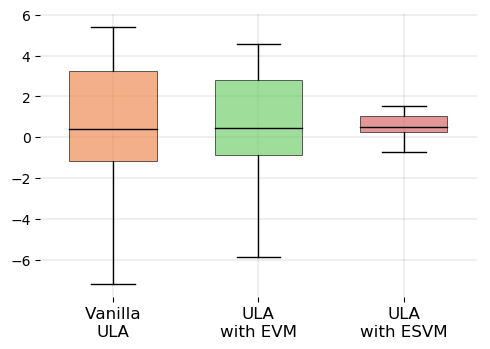

In [26]:
# Box plot
data = [res_arr[:,0,0,var_ind],res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

In [27]:
vars_vanilla = res_arr[:,1,0,:]
vars_esvm_1st = res_arr[:,1,1,:]
vars_esvm_2nd = res_arr[:,1,2,:]
vars_evm_1st = res_arr[:,1,3,:]
vars_evm_2nd = res_arr[:,1,4,:]
print("average VRF for 1st order EVM:",np.mean(vars_vanilla/vars_evm_1st))
print("average VRF for 2nd order EVM:",np.mean(vars_vanilla/vars_evm_2nd))
print("average VRF for 1st order ESVM:",np.mean(vars_vanilla/vars_esvm_1st))
print("average VRF for 2nd order ESVM:",np.mean(vars_vanilla/vars_esvm_2nd))

average VRF for 1st order EVM: 1.0095666692059952
average VRF for 2nd order EVM: 1.4394460413609838
average VRF for 1st order ESVM: 1.0163615591919957
average VRF for 2nd order ESVM: 4.804519396781161
